In [1]:
import torch
print(f"Pytorch vede la GPU? {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Nome GPU: {torch.cuda.get_device_name(0)}")
else:
    print("⚠️ ATTENZIONE: Stai usando la CPU! Installa la versione CUDA di Pytorch.")

Pytorch vede la GPU? True
Nome GPU: Quadro P5000


In [4]:
from openai import OpenAI

# CONFIGURA IL TUO ENDPOINT LM STUDIO REMOTO
LMSTUDIO_HOST = "http://127.0.0.1:1234/v1"   # <-- cambia IP:PORT
client = OpenAI(base_url=LMSTUDIO_HOST, api_key="lm-studio")

# LISTA DEI MODELLI DISPONIBILI SU LM STUDIO
def list_models():
    models = client.models.list()
    print("Modelli disponibili:")
    for m in models.data:
        print(" -", m.id)

list_models()


Modelli disponibili:
 - google/gemma-3-12b
 - qwen/qwen3-vl-8b:2
 - qwen/qwen3-vl-8b
 - text-embedding-nomic-embed-text-v1.5
 - qwen/qwen3-vl-4b
 - whisper-large-v3-turbo
 - openai/gpt-oss-20b
 - deepseek/deepseek-r1-0528-qwen3-8b


In [2]:
from qdrant_client import QdrantClient
print("Tento di inizializzare il client...")
client = QdrantClient("localhost", port=6333)

print(f"Metodi disponibili: {[x for x in dir(client) if 'search' in x]}")

if hasattr(client, 'search'):
    print("✅ SUCCESSO: Il metodo .search() esiste!")
else:
    print("❌ ERRORE: Ancora nessun metodo search.")

Tento di inizializzare il client...
Metodi disponibili: ['search', 'search_batch', 'search_groups']
✅ SUCCESSO: Il metodo .search() esiste!


In [3]:
import qdrant_client
import os

print(f"📂 PERCORSO LIBRERIA: {os.path.dirname(qdrant_client.__file__)}")

📂 PERCORSO LIBRERIA: e:\Dev\FinancialAI\venv\Lib\site-packages\qdrant_client


In [1]:
from qdrant_client import QdrantClient
print("------------------------------------------------")
# Inizializziamo il client (senza parametri complessi)
client = QdrantClient("localhost", port=6333)

# Controlliamo se il metodo 'search' esiste nell'oggetto
methods = dir(client)
if 'search' in methods:
    print("✅ SUCCESSO TOTALE: Il metodo .search() è presente!")
    print("   Puoi lanciare rag_chat_12b.py")
else:
    print("❌ ERRORE: Metodo search ancora assente.")
    print(f"   Metodi simili trovati: {[m for m in methods if 'search' in m]}")
print("------------------------------------------------")

------------------------------------------------
✅ SUCCESSO TOTALE: Il metodo .search() è presente!
   Puoi lanciare rag_chat_12b.py
------------------------------------------------


In [2]:
import sys
import time
from openai import OpenAI
from colorama import init, Fore, Style

# Inizializza colori per il terminale
init(autoreset=True)

# ================= CONFIGURAZIONE =================
# Assicurati che questi parametri corrispondano a LM Studio
LM_STUDIO_URL = "http://localhost:1234/v1"
API_KEY = "lm-studio"  # Convenzione, LM Studio di solito la ignora
# ==================================================

def log_info(msg): print(f"{Fore.CYAN}ℹ️  {msg}{Style.RESET_ALL}")
def log_success(msg): print(f"{Fore.GREEN}✅ {msg}{Style.RESET_ALL}")
def log_warn(msg): print(f"{Fore.YELLOW}⚠️  {msg}{Style.RESET_ALL}")
def log_error(msg): print(f"{Fore.RED}❌ {msg}{Style.RESET_ALL}")

def main():
    print(f"\n{Fore.WHITE}{Style.BRIGHT}=== LM Studio Diagnostic Tool ==={Style.RESET_ALL}\n")
    
    # 1. INIT CLIENT
    log_info(f"Tentativo di connessione a: {LM_STUDIO_URL}...")
    try:
        client = OpenAI(base_url=LM_STUDIO_URL, api_key=API_KEY)
    except Exception as e:
        log_error(f"Errore inizializzazione client: {e}")
        return

    # 2. LIST MODELS (Check Server Status)
    try:
        models_response = client.models.list()
        loaded_models = models_response.data
        
        if not loaded_models:
            log_warn("Il server è raggiungibile, ma NESSUN modello sembra caricato.")
            log_info("Vai su LM Studio -> Server Tab -> Clicca 'Load Model'.")
            return
            
        log_success(f"Server Connesso! Modelli trovati: {len(loaded_models)}")
        
        # Prendiamo il primo modello (di solito è quello attivo)
        active_model_id = loaded_models[0].id
        print(f"   🎯 Modello Attivo: {Fore.MAGENTA}{active_model_id}{Style.RESET_ALL}")
        
    except Exception as e:
        log_error(f"Impossibile connettersi al server. LM Studio è avviato? La porta 1234 è corretta?")
        print(f"   Dettagli errore: {e}")
        return

    # 3. TEST CHAT INFERENCE (Standard)
    log_info("Test 1: Generazione Testo Semplice...")
    start_time = time.time()
    
    try:
        response = client.chat.completions.create(
            model=active_model_id,
            messages=[
                {"role": "system", "content": "Sei un assistente utile."},
                {"role": "user", "content": "Rispondi con una sola parola: sei pronto?"}
            ],
            temperature=0.7,
            max_tokens=50
        )
        elapsed = time.time() - start_time
        content = response.choices[0].message.content
        log_success(f"Risposta ricevuta in {elapsed:.2f}s:")
        print(f"   🤖 AI: {content.strip()}\n")
        
    except Exception as e:
        log_error(f"Errore durante l'inferenza testo: {e}")

    # 4. TEST STREAMING (Opzionale ma utile per UI come Reflex)
    log_info("Test 2: Generazione Streaming...")
    try:
        stream = client.chat.completions.create(
            model=active_model_id,
            messages=[{"role": "user", "content": "Conta da 1 a 3."}],
            stream=True
        )
        print("   🤖 Stream: ", end="", flush=True)
        for chunk in stream:
            if chunk.choices[0].delta.content:
                print(chunk.choices[0].delta.content, end="", flush=True)
        print() # Newline
        log_success("Streaming completato correttamente.\n")
        
    except Exception as e:
        log_error(f"Errore durante lo streaming: {e}")

    # 5. VISION CAPABILITY CHECK (Euristico)
    # Controlliamo solo se il nome del modello suggerisce capacità visive
    vision_keywords = ["vl", "vision", "llava", "bakllava", "qwen-vl"]
    is_vision = any(k in active_model_id.lower() for k in vision_keywords)
    
    if is_vision:
        log_success(f"Il modello '{active_model_id}' sembra essere un modello VISION (Multimodale).")
        log_info("Puoi usare questo modello per analizzare le immagini nel tuo script di ingestion.")
    else:
        log_warn(f"Il modello '{active_model_id}' sembra essere solo TEXT-ONLY.")
        log_info("Se ti serve analizzare PDF con grafici, carica un modello come 'qwen2-vl' o 'llava'.")

    print(f"\n{Fore.WHITE}{Style.BRIGHT}=== Test Completato ==={Style.RESET_ALL}")

if __name__ == "__main__":
    main()


=== LM Studio Diagnostic Tool ===

ℹ️  Tentativo di connessione a: http://localhost:1234/v1...
✅ Server Connesso! Modelli trovati: 8
   🎯 Modello Attivo: google/gemma-3-12b
ℹ️  Test 1: Generazione Testo Semplice...
✅ Risposta ricevuta in 13.46s:
   🤖 AI: Sì.

ℹ️  Test 2: Generazione Streaming...
   🤖 Stream: 1...
2...
3! 🎉

✅ Streaming completato correttamente.

⚠️  Il modello 'google/gemma-3-12b' sembra essere solo TEXT-ONLY.
ℹ️  Se ti serve analizzare PDF con grafici, carica un modello come 'qwen2-vl' o 'llava'.

=== Test Completato ===


In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA


# Crea un DataFrame con le date e i dati
data=['1/1/2026','1/2/2026','1/3/2026','1/4/2026','1/5/2026','1/6/2026','1/7/2026','1/8/2026','1/9/2026','1/10/2026','1/11/2026','1/12/2026','1/13/2026','1/14/2026','1/15/2026','1/16/2026','1/17/2026','1/18/2026','1/19/2026','1/20/2026','1/21/2026','1/22/2026']
dati=[2,3,4,5,8,9,7,6,5,4,3,2,1,4,5,9,7,5,6,3,2,5]

# Crea DataFrame con due colonne
df = pd.DataFrame({'data': data, 'valori': dati})

# Imposta la colonna 'data' come indice
df = df.set_index('data')

print(df)

# Prova un modello ARIMA(1, 0, 1) (questo è solo un esempio, i parametri reali devono essere stimati)
model = ARIMA(df['valori'], order=(1, 0, 1))
model_fit = model.fit()

# Stampa il riepilogo del modello
print(model_fit.summary())

# Previsione (solo a scopo illustrativo)
forecast = model_fit.get_forecast(steps=5)
print(forecast.summary_frame())


           valori
data             
1/1/2026        2
1/2/2026        3
1/3/2026        4
1/4/2026        5
1/5/2026        8
1/6/2026        9
1/7/2026        7
1/8/2026        6
1/9/2026        5
1/10/2026       4
1/11/2026       3
1/12/2026       2
1/13/2026       1
1/14/2026       4
1/15/2026       5
1/16/2026       9
1/17/2026       7
1/18/2026       5
1/19/2026       6
1/20/2026       3
1/21/2026       2
1/22/2026       5
                               SARIMAX Results                                
Dep. Variable:                 valori   No. Observations:                   22
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -42.419
Date:                Thu, 15 Jan 2026   AIC                             92.839
Time:                        12:53:25   BIC                             97.203
Sample:                    01-01-2026   HQIC                            93.867
                         - 01-22-2026                                         
Covariance Type

e:\Dev\FinancialAI\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
e:\Dev\FinancialAI\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
e:\Dev\FinancialAI\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


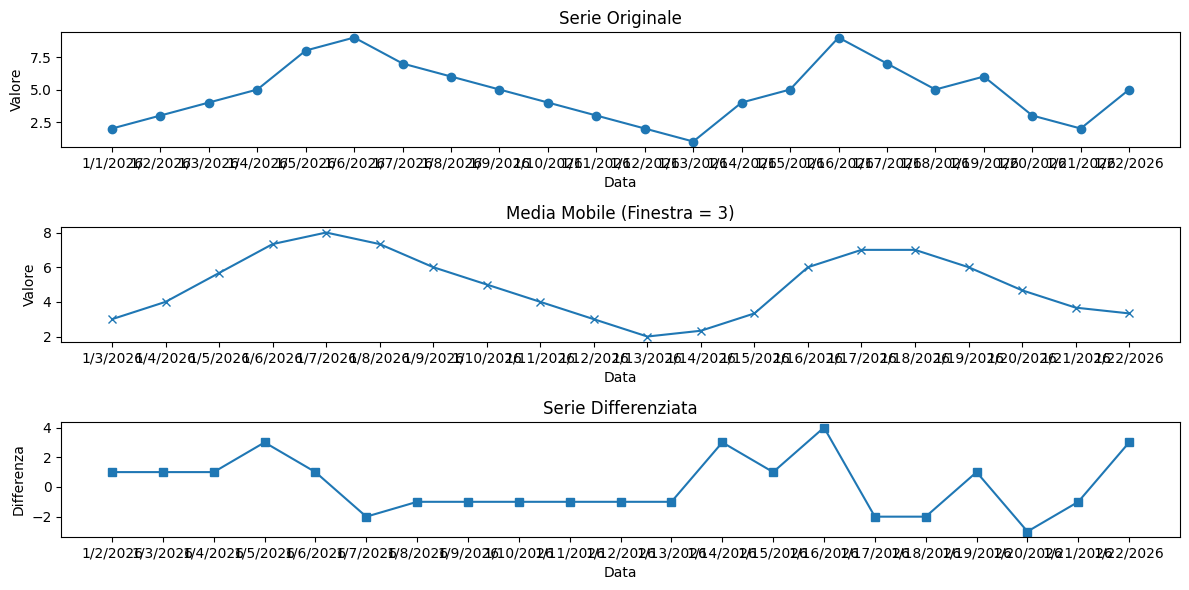

In [1]:
import numpy as np
import matplotlib.pyplot as plt

data = ['1/1/2026','1/2/2026','1/3/2026','1/4/2026','1/5/2026','1/6/2026','1/7/2026','1/8/2026','1/9/2026','1/10/2026','1/11/2026','1/12/2026','1/13/2026','1/14/2026','1/15/2026','1/16/2026','1/17/2026','1/18/2026','1/19/2026','1/20/2026','1/21/2026','1/22/2026']
dati = [2,3,4,5,8,9,7,6,5,4,3,2,1,4,5,9,7,5,6,3,2,5]

# Calcolo della media mobile
window_size = 3
moving_average = np.convolve(dati, np.ones(window_size), 'valid') / window_size

# Differenziazione
diff = np.diff(dati)

# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.plot(data[:len(dati)], dati, marker='o')
plt.title('Serie Originale')
plt.xlabel('Data')
plt.ylabel('Valore')

plt.subplot(3, 1, 2)
plt.plot(data[window_size-1:len(dati)], moving_average, marker='x')
plt.title('Media Mobile (Finestra = {})'.format(window_size))
plt.xlabel('Data')
plt.ylabel('Valore')

plt.subplot(3, 1, 3)
plt.plot(data[1:len(dati)], diff, marker='s')
plt.title('Serie Differenziata')
plt.xlabel('Data')
plt.ylabel('Differenza')

plt.tight_layout()
plt.show()

In [1]:
from huggingface_hub import snapshot_download

# Definisci dove vuoi salvare il modello
local_dir = "E:/Modelli/bge-m3"

print(f"Inizio download del modello in: {local_dir}...")

snapshot_download(
    repo_id="BAAI/bge-m3",
    local_dir=local_dir,
    local_dir_use_symlinks=False,
    revision="main"
)

print("Download completato con successo!")

e:\Dev\FinancialAI\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Inizio download del modello in: E:/Modelli/bge-m3...


e:\Dev\FinancialAI\venv\Lib\site-packages\huggingface_hub\file_download.py:979: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(
Fetching 30 files:   7%|▋         | 2/30 [00:06<01:31,  3.28s/it]'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 3a464be2-7158-49e2-ba9e-972d8a026caf)')' thrown while requesting HEAD https://huggingface.co/BAAI/bge-m3/resolve/5617a9f61b028005a4858fdac845db406aefb181/imgs/long.jpg
'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 00129cff-6f43-4bf0-85a7-f6677bdd3030)')' thrown w

Download completato con successo!


In [2]:
from huggingface_hub import snapshot_download

# Definisci il percorso per il Reranker
reranker_dir = "E:/Modelli/ms-marco-reranker"

print(f"Inizio download del Reranker in: {reranker_dir}...")

snapshot_download(
    repo_id="cross-encoder/ms-marco-MiniLM-L-6-v2",
    local_dir=reranker_dir,
    local_dir_use_symlinks=False,
    revision="main"
)

print("Download del Reranker completato!")

Inizio download del Reranker in: E:/Modelli/ms-marco-reranker...


Fetching 23 files:   4%|▍         | 1/23 [00:03<01:26,  3.95s/it]'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 0b7e0418-1e81-4192-8050-cc83b05ffef1)')' thrown while requesting HEAD https://huggingface.co/cross-encoder/ms-marco-MiniLM-L-6-v2/resolve/c5ee24cb16019beea0893ab7796b1df96625c6b8/config.json
Retrying in 1s [Retry 1/5].
Fetching 23 files:  13%|█▎        | 3/23 [00:18<02:05,  6.27s/it]'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 27bab0b7-f03f-42d9-874b-8384555ab938)')' thrown while requesting HEAD https://huggingface.co/cross-encoder/ms-marco-MiniLM-L-6-v2/resolve/c5ee24cb16019beea0893ab7796b1df96625c6b8/onnx/model_qint8_avx512.onnx
Retrying in 1s [Retry 1/5].
Fetching 23 files:  17%|█▋        | 4/23 [00:47<04:28, 14.16s/it]'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read time

Download del Reranker completato!


In [5]:
from pypdf import PdfReader, PdfWriter

reader = PdfReader("FINANZA_COMPORTAMENTALE_CONSULENZA.pdf")
writer = PdfWriter()

# pagine 3 e 4 (attenzione: indice da 0)
writer.add_page(reader.pages[32])
#writer.add_page(reader.pages[15])

with open("FINANZA_COMPORTAMENTALE_CONSULENZA_out.pdf", "wb") as f:
    writer.write(f)

In [2]:
from huggingface_hub import snapshot_download

local_dir = "E:/Modelli/qwen3-vl-8b-instruct"

snapshot_download(
    repo_id="Qwen/Qwen3-VL-8B-Instruct",
    local_dir=local_dir,
    local_dir_use_symlinks=False,
    revision="main",
)
print("OK")


Fetching 16 files: 100%|██████████| 16/16 [21:25<00:00, 80.37s/it]

OK


In [1]:
from huggingface_hub import snapshot_download

local_dir = "E:/Modelli/qwen3-vl-8b-gguf"

print("Download Q4_K_M in corso...")

snapshot_download(
    repo_id="Qwen/Qwen3-VL-8B-Instruct-GGUF",
    local_dir=local_dir,
    local_dir_use_symlinks=False,
    allow_patterns=["*Q4_K_M.gguf"]
)

print("Download completato!")


e:\Dev\FinancialAI\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Download Q4_K_M in corso...


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]e:\Dev\FinancialAI\venv\Lib\site-packages\huggingface_hub\file_download.py:979: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(
Fetching 1 files: 100%|██████████| 1/1 [07:53<00:00, 473.39s/it]

Download completato!


In [ ]:
import fitz

doc = fitz.open("Formulae_Tables.pdf")
for i, page in enumerate(doc):
    print(f"\n--- PAGE {i+1} ---\n")
    print(page.get_text())


In [ ]:
import fitz, pytesseract
from PIL import Image
import io

page = fitz.open("Formulae_Tables.pdf")[0]
pix = page.get_pixmap(dpi=300)
img = Image.open(io.BytesIO(pix.tobytes("png")))
print(pytesseract.image_to_string(img, lang="eng"))


In [6]:
import fitz
import re

PDF_PATH = r"Formulae_Tables.pdf"

def clean(s: str) -> str:
    # rimuove caratteri di controllo / glifi strani (mantiene newline e tab)
    s = s.replace("\x00", "")
    s = re.sub(r"[^\x09\x0A\x0D\x20-\x7E\u00A0-\u017F\u0370-\u03FF]", "", s)
    s = re.sub(r"[ \t]+", " ", s)
    return s

doc = fitz.open(PDF_PATH)
print("Pages:", len(doc))

for i, page in enumerate(doc):
    print(f"\n================== PAGE {i+1} ==================\n")

    plain = clean(page.get_text("text"))
    print("----- TEXT (plain) -----\n", plain[:2000])

    blocks = page.get_text("blocks")
    blocks_sorted = sorted(blocks, key=lambda b: (round(b[1], 1), round(b[0], 1)))  # y, x
    blocks_txt = "\n".join(clean(b[4]) for b in blocks_sorted if b[4].strip())
    print("\n----- TEXT (blocks sorted y,x) -----\n", blocks_txt[:2000])

    d = page.get_text("dict")
    lines = []
    for block in d.get("blocks", []):
        for line in block.get("lines", []):
            line_txt = "".join(span.get("text","") for span in line.get("spans", []))
            if line_txt.strip():
                lines.append((line["bbox"][1], line["bbox"][0], clean(line_txt)))  # y,x,text
    lines_sorted = sorted(lines, key=lambda t: (round(t[0], 1), round(t[1], 1)))
    dict_txt = "\n".join(t[2] for t in lines_sorted)
    print("\n----- TEXT (dict->lines sorted y,x) -----\n", dict_txt[:])


Pages: 3

================== PAGE 1 ==================

----- TEXT (plain) -----
 S17
1
Financial Management (FM)
Formulae sheet and maths tables
Formulae Sheet 
Economic order quantity 
=
2C0D
Ch
MillerOrr Model 
The Capital Asset Pricing Model 
E ri( ) = Rf + βi E rm
( ) Rf
(
)
The asset beta formula 
 
The Growth Model 
Gordons growth approximation 
g = bre 
The weighted average cost of capital 
The Fisher formula 
1+ i
(
) = 1+ r
(
) 1+ h
(
)
Purchasing power parity and interest rate parity 
S1 = S0 × 1+ hc
(
)
1+ hb
(
)
 F0 = S0 × 1+ ic
(
)
1+ ib
(
)
Return point = Lower limit + ( 1
3
spread
Spr
×
)
ead
transaction cost
variance of cash
=
×
×
3
3
4
flows
interest rate


³
³


µ
µ
1
3
β
β
a
e
e
d
e
d
e
d
V
V
V
T
V
T
V
V
=
+
(
)
(
)


³
³
³


µ
µ
µ
+
(
)
+
1
1
1


 T
d
(
)
(
)


³
³
³


µ
µ
µ
β
WACC
V
V
V
k
V
V
V
k
T
e
e
d
e
d
e
d
d
=
+


³
³


µ
µ
+
+


³
³


µ
µ
1 
(
)


----- TEXT (blocks sorted y,x) -----
 Financial Management (FM)
Formulae sheet and maths tables

Formulae Sheet

In [5]:
from pathlib import Path

out_dir = Path("pdf_text_debug")
out_dir.mkdir(exist_ok=True)

doc = fitz.open(PDF_PATH)
for i, page in enumerate(doc):
    plain = clean(page.get_text("text"))

    blocks = page.get_text("blocks")
    blocks_sorted = sorted(blocks, key=lambda b: (round(b[1], 1), round(b[0], 1)))
    blocks_txt = "\n".join(clean(b[4]) for b in blocks_sorted if b[4].strip())

    d = page.get_text("dict")
    lines = []
    for block in d.get("blocks", []):
        for line in block.get("lines", []):
            line_txt = "".join(span.get("text","") for span in line.get("spans", []))
            if line_txt.strip():
                lines.append((line["bbox"][1], line["bbox"][0], clean(line_txt)))
    lines_sorted = sorted(lines, key=lambda t: (round(t[0], 1), round(t[1], 1)))
    dict_txt = "\n".join(t[2] for t in lines_sorted)

    (out_dir / f"page_{i+1:02d}_plain.txt").write_text(plain, encoding="utf-8")
    (out_dir / f"page_{i+1:02d}_blocks.txt").write_text(blocks_txt, encoding="utf-8")
    (out_dir / f"page_{i+1:02d}_dict.txt").write_text(dict_txt, encoding="utf-8")

print("Saved in:", out_dir.resolve())


Saved in: E:\Dev\FinancialAI\pdf_text_debug


🔄 Caricamento: Formulae_Tables.pdf (Pagina 1)...
✅ Pagina renderizzata (212104 chars base64). Ecco cosa vedrà il modello:


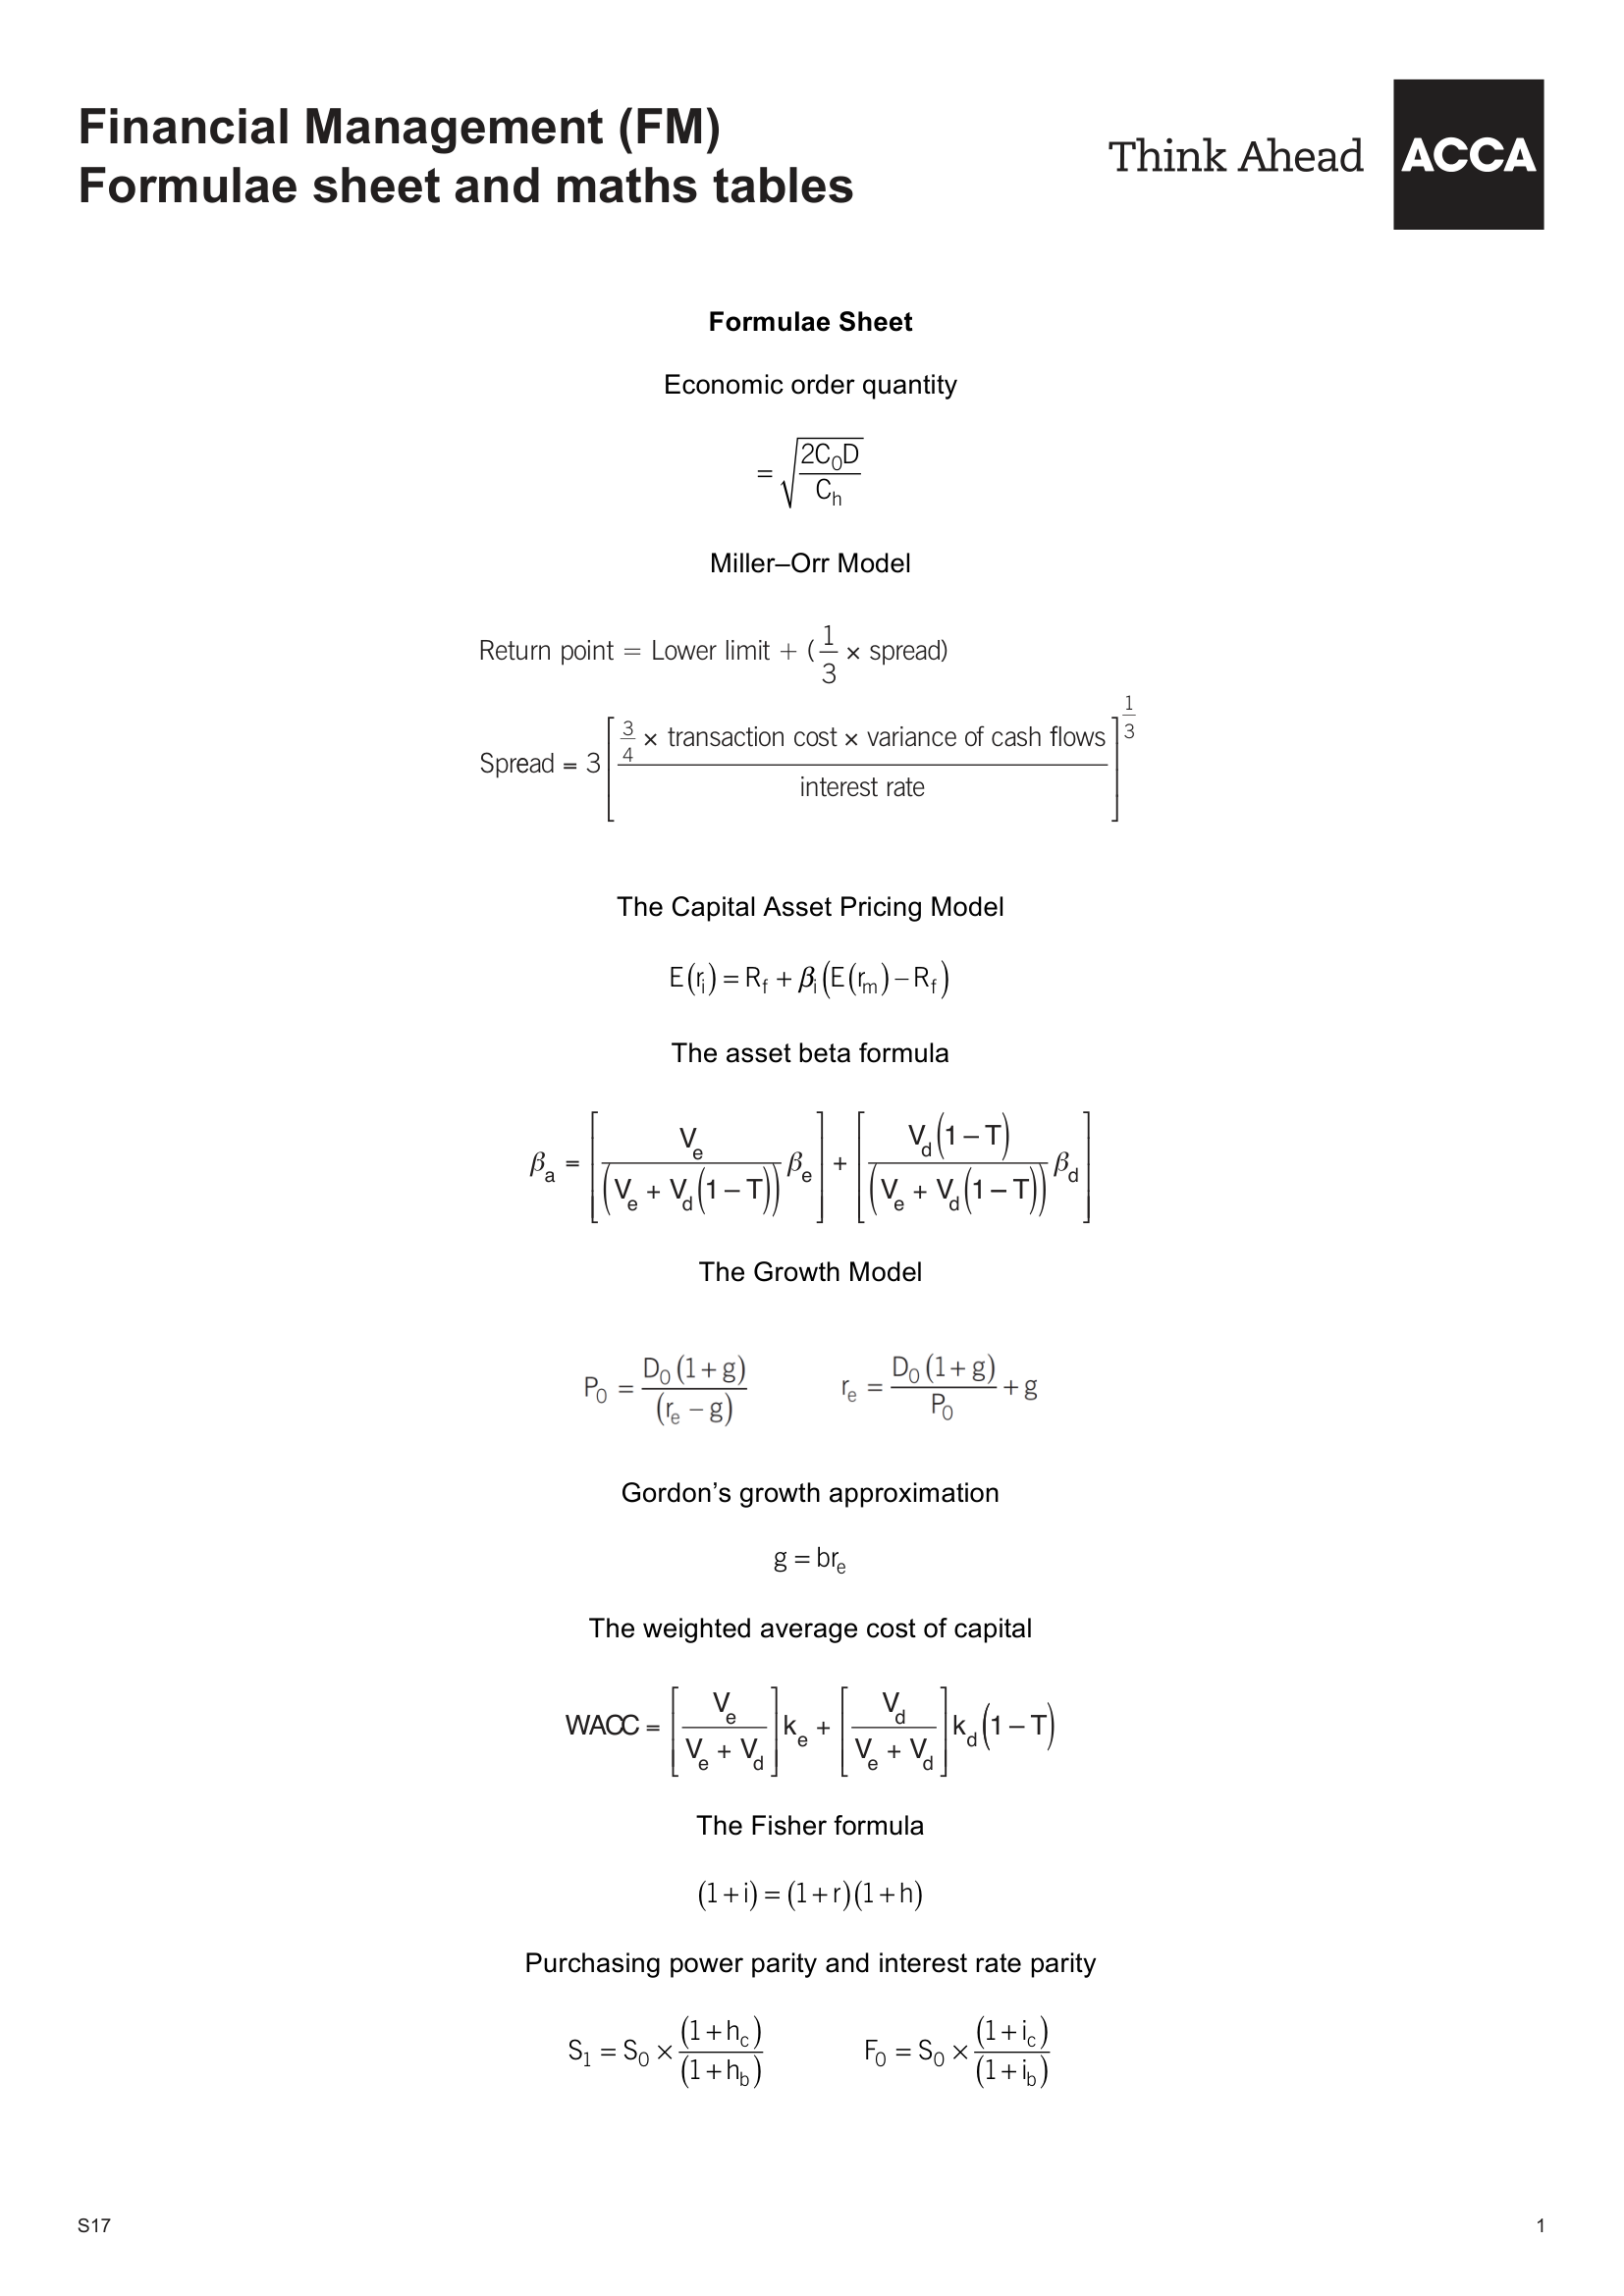


🚀 Invio richiesta a Ollama (Modello: qwen3-8b-gguf)... attendere...
❌ ERRORE API OLLAMA: 500
{"error":"do load request: Post \"http://127.0.0.1:58693/load\": EOF"}


In [18]:
# 1. INSTALLAZIONE LIBRERIE (Se non le hai già, togli il commento alla riga sotto ed esegui una volta)
# !pip install pymupdf requests ipython

import os
import fitz  # PyMuPDF
import base64
import requests
import json
from IPython.display import display, Image, Markdown

# ================= CONFIGURAZIONE =================
# ⚠️ IMPORTANTE: Assicurati che questo sia un modello VISION (es. qwen2.5-vl), 
# altrimenti darà errore o allucinazioni se è solo testo.
#LLM_MODEL_NAME = os.getenv("LLM_MODEL_NAME", "gemma3:12b-finstudio")

LLM_MODEL_NAME = os.getenv("LLM_MODEL_NAME", "qwen3-8b-gguf") 

# Percorso del PDF
PDF_PATH = "Formulae_Tables.pdf" 

# Pagina da testare (0 = prima pagina)
PAGE_INDEX = 0 

# Prompt "Vision Supremacy"
PROMPT = """
You are a Scientific OCR Engine.
Transcribe the visual content of this page.
Ignore corrupt text artifacts like '2C0D'.
Identify formulas and write them in standard LaTeX.
Identify tables and write them in Markdown.
"""

# ================= FUNZIONI DI TEST =================

def test_vision_notebook():
    print(f"🔄 Caricamento: {PDF_PATH} (Pagina {PAGE_INDEX + 1})...")
    
    if not os.path.exists(PDF_PATH):
        print("❌ ERRORE: File PDF non trovato! Verifica il percorso.")
        return

    # --- 1. RENDERING IMMAGINE ---
    try:
        doc = fitz.open(PDF_PATH)
        page = doc.load_page(PAGE_INDEX)
        
        # 200 DPI è ottimale per Qwen
        pix = page.get_pixmap(dpi=200)
        img_bytes = pix.tobytes("png")
        
        # Encoding Base64 per Ollama
        img_b64 = base64.b64encode(img_bytes).decode('utf-8')
        
        print(f"✅ Pagina renderizzata ({len(img_b64)} chars base64). Ecco cosa vedrà il modello:")
        
        # MOSTRA L'IMMAGINE NEL NOTEBOOK (Feature specifica Jupyter)
        display(Image(data=img_bytes, width=600))
        
        doc.close()
    except Exception as e:
        print(f"❌ ERRORE Rendering PDF: {e}")
        return

    # --- 2. CHIAMATA OLLAMA ---
    print(f"\n🚀 Invio richiesta a Ollama (Modello: {LLM_MODEL_NAME})... attendere...")
    
    url = "http://localhost:11434/api/chat"
    payload = {
        "model": LLM_MODEL_NAME,
        "messages": [
            {
                "role": "user",
                "content": PROMPT,
                "images": [img_b64]
            }
        ],
        "stream": False,
        "options": {
            "temperature": 0.1, # Zero creatività, solo lettura
            "num_ctx": 4096
        }
    }

    try:
        response = requests.post(url, json=payload)
        
        if response.status_code != 200:
            print(f"❌ ERRORE API OLLAMA: {response.status_code}")
            print(response.text)
            if response.status_code == 400:
                print("💡 SUGGERIMENTO: Se l'errore è 'images not supported', il modello scelto è SOLO TESTO. Usa 'qwen2.5-vl'.")
            return
        
        result = response.json()
        content = result.get("message", {}).get("content", "Nessun contenuto.")
        
        print("\n" + "="*40)
        print("📝 RISPOSTA DEL MODELLO")
        print("="*40 + "\n")
        
        # Renderizza il Markdown direttamente nel notebook
        display(Markdown(content))
        
        # Stampa anche raw per vedere il LaTeX puro
        print("\n--- RAW OUTPUT ---")
        print(content)
        
    except requests.exceptions.ConnectionError:
        print("❌ ERRORE CONNESSIONE: Ollama non risponde su localhost:11434")
    except Exception as e:
        print(f"❌ ERRORE: {e}")

# ================= ESECUZIONE =================
test_vision_notebook()

🔄 Caricamento: Formulae_Tables.pdf (Pagina 1)...


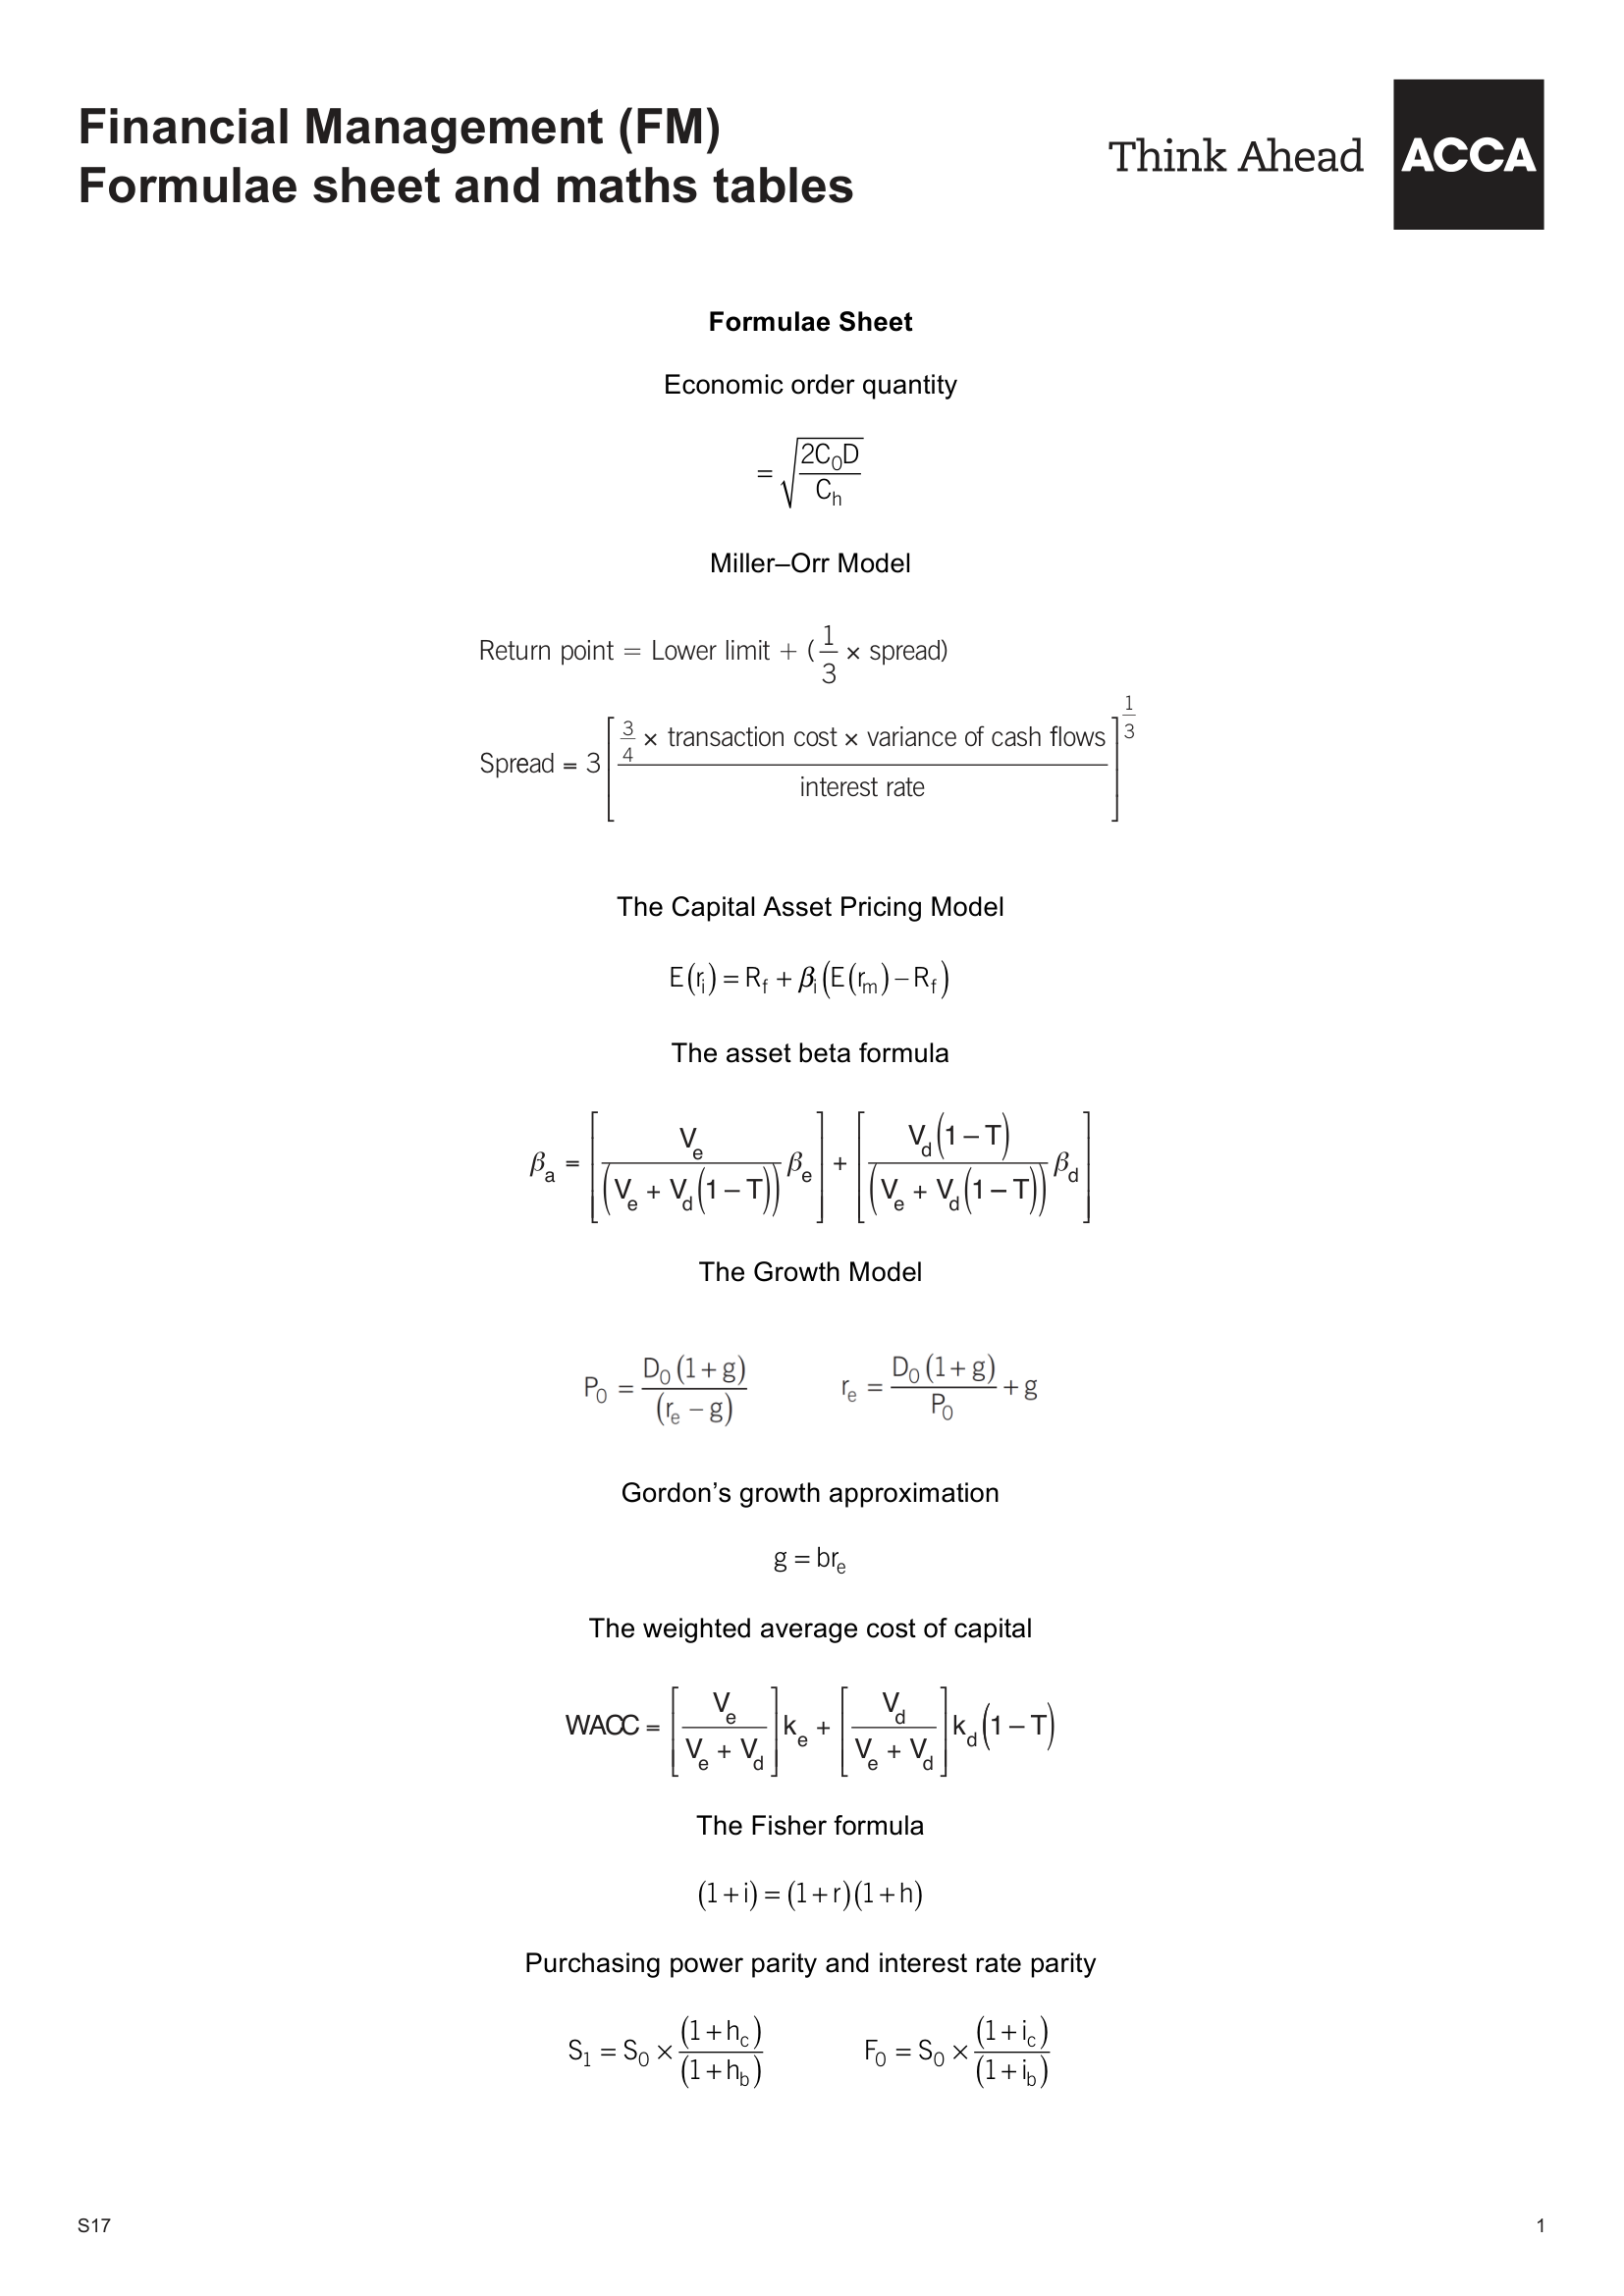


🚀 Invio richiesta a Ollama (qwen3-8b-gguf)...
❌ ERRORE API: 500 - {"error":"do load request: Post \"http://127.0.0.1:54189/load\": EOF"}


In [20]:
import os
import fitz  # PyMuPDF
import base64
import requests
import json
from IPython.display import display, Image, Markdown

# ================= CONFIGURAZIONE =================
# ✅ FIX CRUCIALE: Usiamo il modello VISION ufficiale
LLM_MODEL_NAME = "qwen3-8b-gguf"  

# Percorso del PDF
PDF_PATH = "Formulae_Tables.pdf" 
PAGE_INDEX = 0 

PROMPT = """
You are a Scientific OCR Engine.
Transcribe the visual content of this page.
Ignore corrupt text artifacts like '2C0D'.
Identify formulas and write them in standard LaTeX.
Identify tables and write them in Markdown.
"""

def test_vision_notebook():
    print(f"🔄 Caricamento: {PDF_PATH} (Pagina {PAGE_INDEX + 1})...")
    
    if not os.path.exists(PDF_PATH):
        print("❌ ERRORE: File PDF non trovato!")
        return

    # 1. RENDERING
    try:
        doc = fitz.open(PDF_PATH)
        page = doc.load_page(PAGE_INDEX)
        pix = page.get_pixmap(dpi=200)
        img_bytes = pix.tobytes("png")
        img_b64 = base64.b64encode(img_bytes).decode('utf-8')
        display(Image(data=img_bytes, width=600))
        doc.close()
    except Exception as e:
        print(f"❌ ERRORE Rendering: {e}")
        return

    # 2. CHIAMATA OLLAMA
    print(f"\n🚀 Invio richiesta a Ollama ({LLM_MODEL_NAME})...")
    
    # URL CORRETTO: /api/chat
    url = "http://localhost:11434/api/chat"
    
    payload = {
        "model": LLM_MODEL_NAME,
        "messages": [
            {
                "role": "user",
                "content": PROMPT,
                "images": [img_b64]
            }
        ],
        "stream": False,
        "options": {"temperature": 0.0}
    }

    try:
        response = requests.post(url, json=payload)
        
        if response.status_code == 200:
            content = response.json().get("message", {}).get("content", "")
            print("\n✅ SUCCESSO! Ecco l'estrazione:\n")
            display(Markdown(content))
            print("\n--- RAW LATEX ---\n", content)
        else:
            print(f"❌ ERRORE API: {response.status_code} - {response.text}")
            
    except Exception as e:
        print(f"❌ ERRORE CONNESSIONE: {e}")

test_vision_notebook()

In [21]:
import os
import subprocess
import time
import requests

def ensure_ollama_parallel(num_parallel="4"):
    """
    Forza il riavvio di Ollama con la configurazione parallela specifica.
    """
    print(f"🚀 Configurazione Ollama: NUM_PARALLEL={num_parallel} (Max Loaded=2)")

    # 1. Imposta variabili per il processo figlio
    os.environ["OLLAMA_NUM_PARALLEL"] = str(num_parallel)
    os.environ["OLLAMA_MAX_LOADED_MODELS"] = "2"
    # IMPORTANTE: Keep Alive mantiene il modello in VRAM per evitare ricaricamenti (5 min)
    os.environ["OLLAMA_KEEP_ALIVE"] = "5m" 

    # 2. TERMINA eventuali istanze esistenti (Per applicare le nuove variabili)
    print("   🔪 Terminazione istanze Ollama esistenti...")
    try:
        # Comando Windows per uccidere il processo
        subprocess.run(["taskkill", "/F", "/IM", "ollama.exe"], 
                       stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
        time.sleep(2) # Dai tempo di morire
    except Exception:
        pass

    # 3. AVVIA il server con le nuove variabili
    print("   🔥 Avvio nuovo server Ollama ottimizzato...")
    try:
        # subprocess.Popen non blocca lo script
        subprocess.Popen(
            ["ollama", "serve"],
            env=os.environ, 
            stdout=subprocess.DEVNULL,
            stderr=subprocess.DEVNULL,
            creationflags=subprocess.CREATE_NEW_CONSOLE # Su Windows evita che chiudendo lo script muoia Ollama
        )
    except FileNotFoundError:
        print("   ❌ Errore: 'ollama' non trovato nel PATH. Installalo o aggiungilo al path.")
        return

    # 4. WAIT LOOP (Attesa attiva)
    print("   ⏳ In attesa che il server sia pronto...", end="", flush=True)
    for _ in range(20): # 20 tentativi (40 secondi max)
        try:
            # Testiamo /api/tags che è leggero
            resp = requests.get("http://localhost:11434/api/tags", timeout=2)
            if resp.status_code == 200:
                print(" ✅ PRONTO!")
                return
        except:
            pass
        print(".", end="", flush=True)
        time.sleep(2)
    
    print("\n   ⚠️ ATTENZIONE: Il server sembra lento ad avviarsi, ma proseguo...")

In [ ]:
import os
import fitz  # PyMuPDF
import base64
import requests
import time

# ================= CONFIGURAZIONE =================
# FILE DA LEGGERE
PDF_PATH = "Formulae_Tables.pdf"

# MODELLO (quello presente in Ollama)
MODEL_NAME = "qwen3-vl-8b"

# URL OLLAMA (FIX DEFINITIVO)
OLLAMA_API = "http://127.0.0.1:11434/api/tags"

# PROMPT
PROMPT = """
You are a Scientific OCR Engine.
Transcribe the visual content of this page.
Ignore corrupt text artifacts like '2C0D'.
Identify formulas and write them in standard LaTeX.
Identify tables and write them in Markdown.
"""

# ================= FUNZIONI =================

def image_to_base64(page):
    """Renderizza la pagina PDF in immagine e la converte in base64"""
    pix = page.get_pixmap(dpi=200)  # DPI corretto per Vision
    img_bytes = pix.tobytes("png")
    return base64.b64encode(img_bytes).decode("utf-8")

def process_pdf_linear():
    print(f"📄 Apertura file: {PDF_PATH}")

    try:
        doc = fitz.open(PDF_PATH)
    except Exception as e:
        print(f"❌ Errore apertura PDF: {e}")
        return

    total_pages = len(doc)
    print(f"📊 Totale pagine: {total_pages}\n")

    # --- CICLO LINEARE ---
    for i, page in enumerate(doc):
        page_num = i + 1
        print(f"🔹 Elaborazione Pagina {page_num}/{total_pages}...", end="", flush=True)

        # 1. Rendering immagine
        try:
            img_b64 = image_to_base64(page)
        except Exception as e:
            print(f" ❌ Errore Rendering: {e}")
            continue

        # 2. Payload Ollama
        payload = {
            "model": MODEL_NAME,
            "messages": [
                {
                    "role": "user",
                    "content": PROMPT,
                    "images": [img_b64]
                }
            ],
            "stream": False,
            "options": {
                "temperature": 0.0,
                "num_ctx": 4096
            }
        }

        # 3. Chiamata API
        try:
            start_time = time.time()

            response = requests.post(
                OLLAMA_API,
                json=payload,
                timeout=300,
                allow_redirects=False
            )

            elapsed = time.time() - start_time

            # Diagnostica redirect
            if response.is_redirect:
                print(f"\n⚠️ Redirect verso: {response.headers.get('Location')}")

            if response.status_code == 200:
                result = response.json()
                content = result.get("message", {}).get("content", "")

                print(f" ✅ Fatto in {elapsed:.1f}s")
                print("-" * 60)
                print(f"--- OUTPUT PAGINA {page_num} ---")
                print(content)
                print("-" * 60 + "\n")
            else:
                print(f"\n❌ Errore API: {response.status_code}")
                print("Content-Type:", response.headers.get("Content-Type", ""))
                print("Body preview:", response.text[:400])

        except Exception as e:
            print(f"\n❌ Errore Connessione: {e}")

    print("🏁 Elaborazione completata.")

# ================= MAIN =================

if __name__ == "__main__":
    process_pdf_linear()


📄 Apertura file: Formulae_Tables.pdf
📊 Totale pagine: 3

🔹 Elaborazione Pagina 1/3...
❌ Errore API: 500
Content-Type: application/json; charset=utf-8
Body preview: {"error":"do load request: Post \"http://127.0.0.1:49454/load\": EOF"}
🔹 Elaborazione Pagina 2/3...
❌ Errore API: 500
Content-Type: application/json; charset=utf-8
Body preview: {"error":"do load request: Post \"http://127.0.0.1:49486/load\": EOF"}
🔹 Elaborazione Pagina 3/3...
❌ Errore API: 500
Content-Type: application/json; charset=utf-8
Body preview: {"error":"do load request: Post \"http://127.0.0.1:49515/load\": EOF"}
🏁 Elaborazione completata.


In [ ]:
import os
import fitz  # PyMuPDF
import base64
import requests
import time
from ollama import chat
from ollama import ChatResponse


# ================= CONFIGURAZIONE =================
# FILE DA LEGGERE
PDF_PATH = "Formulae_Tables.pdf"

# MODELLO (quello presente in Ollama)
MODEL_NAME = "qwen3-vl:8b"

# PROMPT
PROMPT = """
You are a Scientific OCR Engine.
Transcribe the visual content of this page.
Ignore corrupt text artifacts like '2C0D'.
Identify formulas and write them in standard LaTeX.
Identify tables and write them in Markdown.
"""

# ================= FUNZIONI =================

def image_to_base64(page):
    """Renderizza la pagina PDF in immagine e la converte in base64"""
    pix = page.get_pixmap(dpi=200)  # DPI corretto per Vision
    img_bytes = pix.tobytes("png")
    return base64.b64encode(img_bytes).decode("utf-8")

def process_pdf_linear():
    print(f"📄 Apertura file: {PDF_PATH}")

    try:
        doc = fitz.open(PDF_PATH)
    except Exception as e:
        print(f"❌ Errore apertura PDF: {e}")
        return

    total_pages = len(doc)
    print(f"📊 Totale pagine: {total_pages}\n")

    # --- CICLO LINEARE ---
    for i, page in enumerate(doc):
        page_num = i + 1
        print(f"🔹 Elaborazione Pagina {page_num}/{total_pages}...", end="", flush=True)

        # 1. Rendering immagine
        try:
            img_b64 = image_to_base64(page)
        except Exception as e:
            print(f" ❌ Errore Rendering: {e}")
            continue

        # 2. Payload Ollama
        payload = {
            "model": MODEL_NAME,
            "messages": [
                {
                    "role": "user",
                    "content": PROMPT,
                    "images": [img_b64]
                }
            ],
            "stream": False,
            "options": {
                "temperature": 0.0,
                "num_ctx": 4096
            }
        }

        # 3. Chiamata API
        try:
            start_time = time.time()

            response : ChatResponse = chat(model=MODEL_NAME, messages=[
                {
                    "role": "user",
                    "content": PROMPT,
                    "images": [img_b64]
                }
            ],
            options={
                "temperature": 0.0,
                "num_ctx": 4096
            }                               
            )

            elapsed = time.time() - start_time


            if response['message']['content']:
                content = response.message.content

                print(f" ✅ Fatto in {elapsed:.1f}s")
                print("-" * 60)
                print(f"--- OUTPUT PAGINA {page_num} ---")
                print(content)
                print("-" * 60 + "\n")
            else:
                print(f"\n❌ Errore")

        except Exception as e:
            print(f"\n❌ Errore: {e}")

    print("🏁 Elaborazione completata.")

# ================= MAIN =================

if __name__ == "__main__":
    process_pdf_linear()


📄 Apertura file: Formulae_Tables.pdf
📊 Totale pagine: 3

🔹 Elaborazione Pagina 1/3... ✅ Fatto in 261.2s
------------------------------------------------------------
--- OUTPUT PAGINA 1 ---
Financial Management (FM) Formulae sheet and maths tables

Think Ahead ACCA

Formulae Sheet

Economic order quantity
$$
\sqrt{\frac{2 C_0 D}{C_h}}
$$

Miller-Orr Model
Return point = Lower limit + $\frac{1}{3} \times \text{spread}$
$$
\text{Spread} = 3 \left[ \frac{\frac{3}{4} \times \text{transaction cost} \times \text{variance of cash flows}}{\text{interest rate}} \right]^{1/3}
$$

The Capital Asset Pricing Model
$$
\text{E}(r_i) = R_f + \beta_i \left( \text{E}(r_m) - R_f \right)
$$

The asset beta formula
$$
\beta_a = \left[ \frac{V_e}{V_e + V_d (1 - T)} \right] \beta_e + \left[ \frac{V_d (1 - T)}{V_e + V_d (1 - T)} \right] \beta_d
$$

The Growth Model
$$
\text{P}_0 = \frac{D_0 (1 + g)}{r_e - g}, \quad r_e = \frac{D_0 (1 + g)}{P_0} + g
$$

Gordon's growth approximation
$$
g = b r_e
$$

The weighte

🔄 Apertura file: Formulae_Tables.pdf (Pagina 1)...
✅ Immagine renderizzata. Ecco cosa vedrà qwen/qwen3-vl-8b:


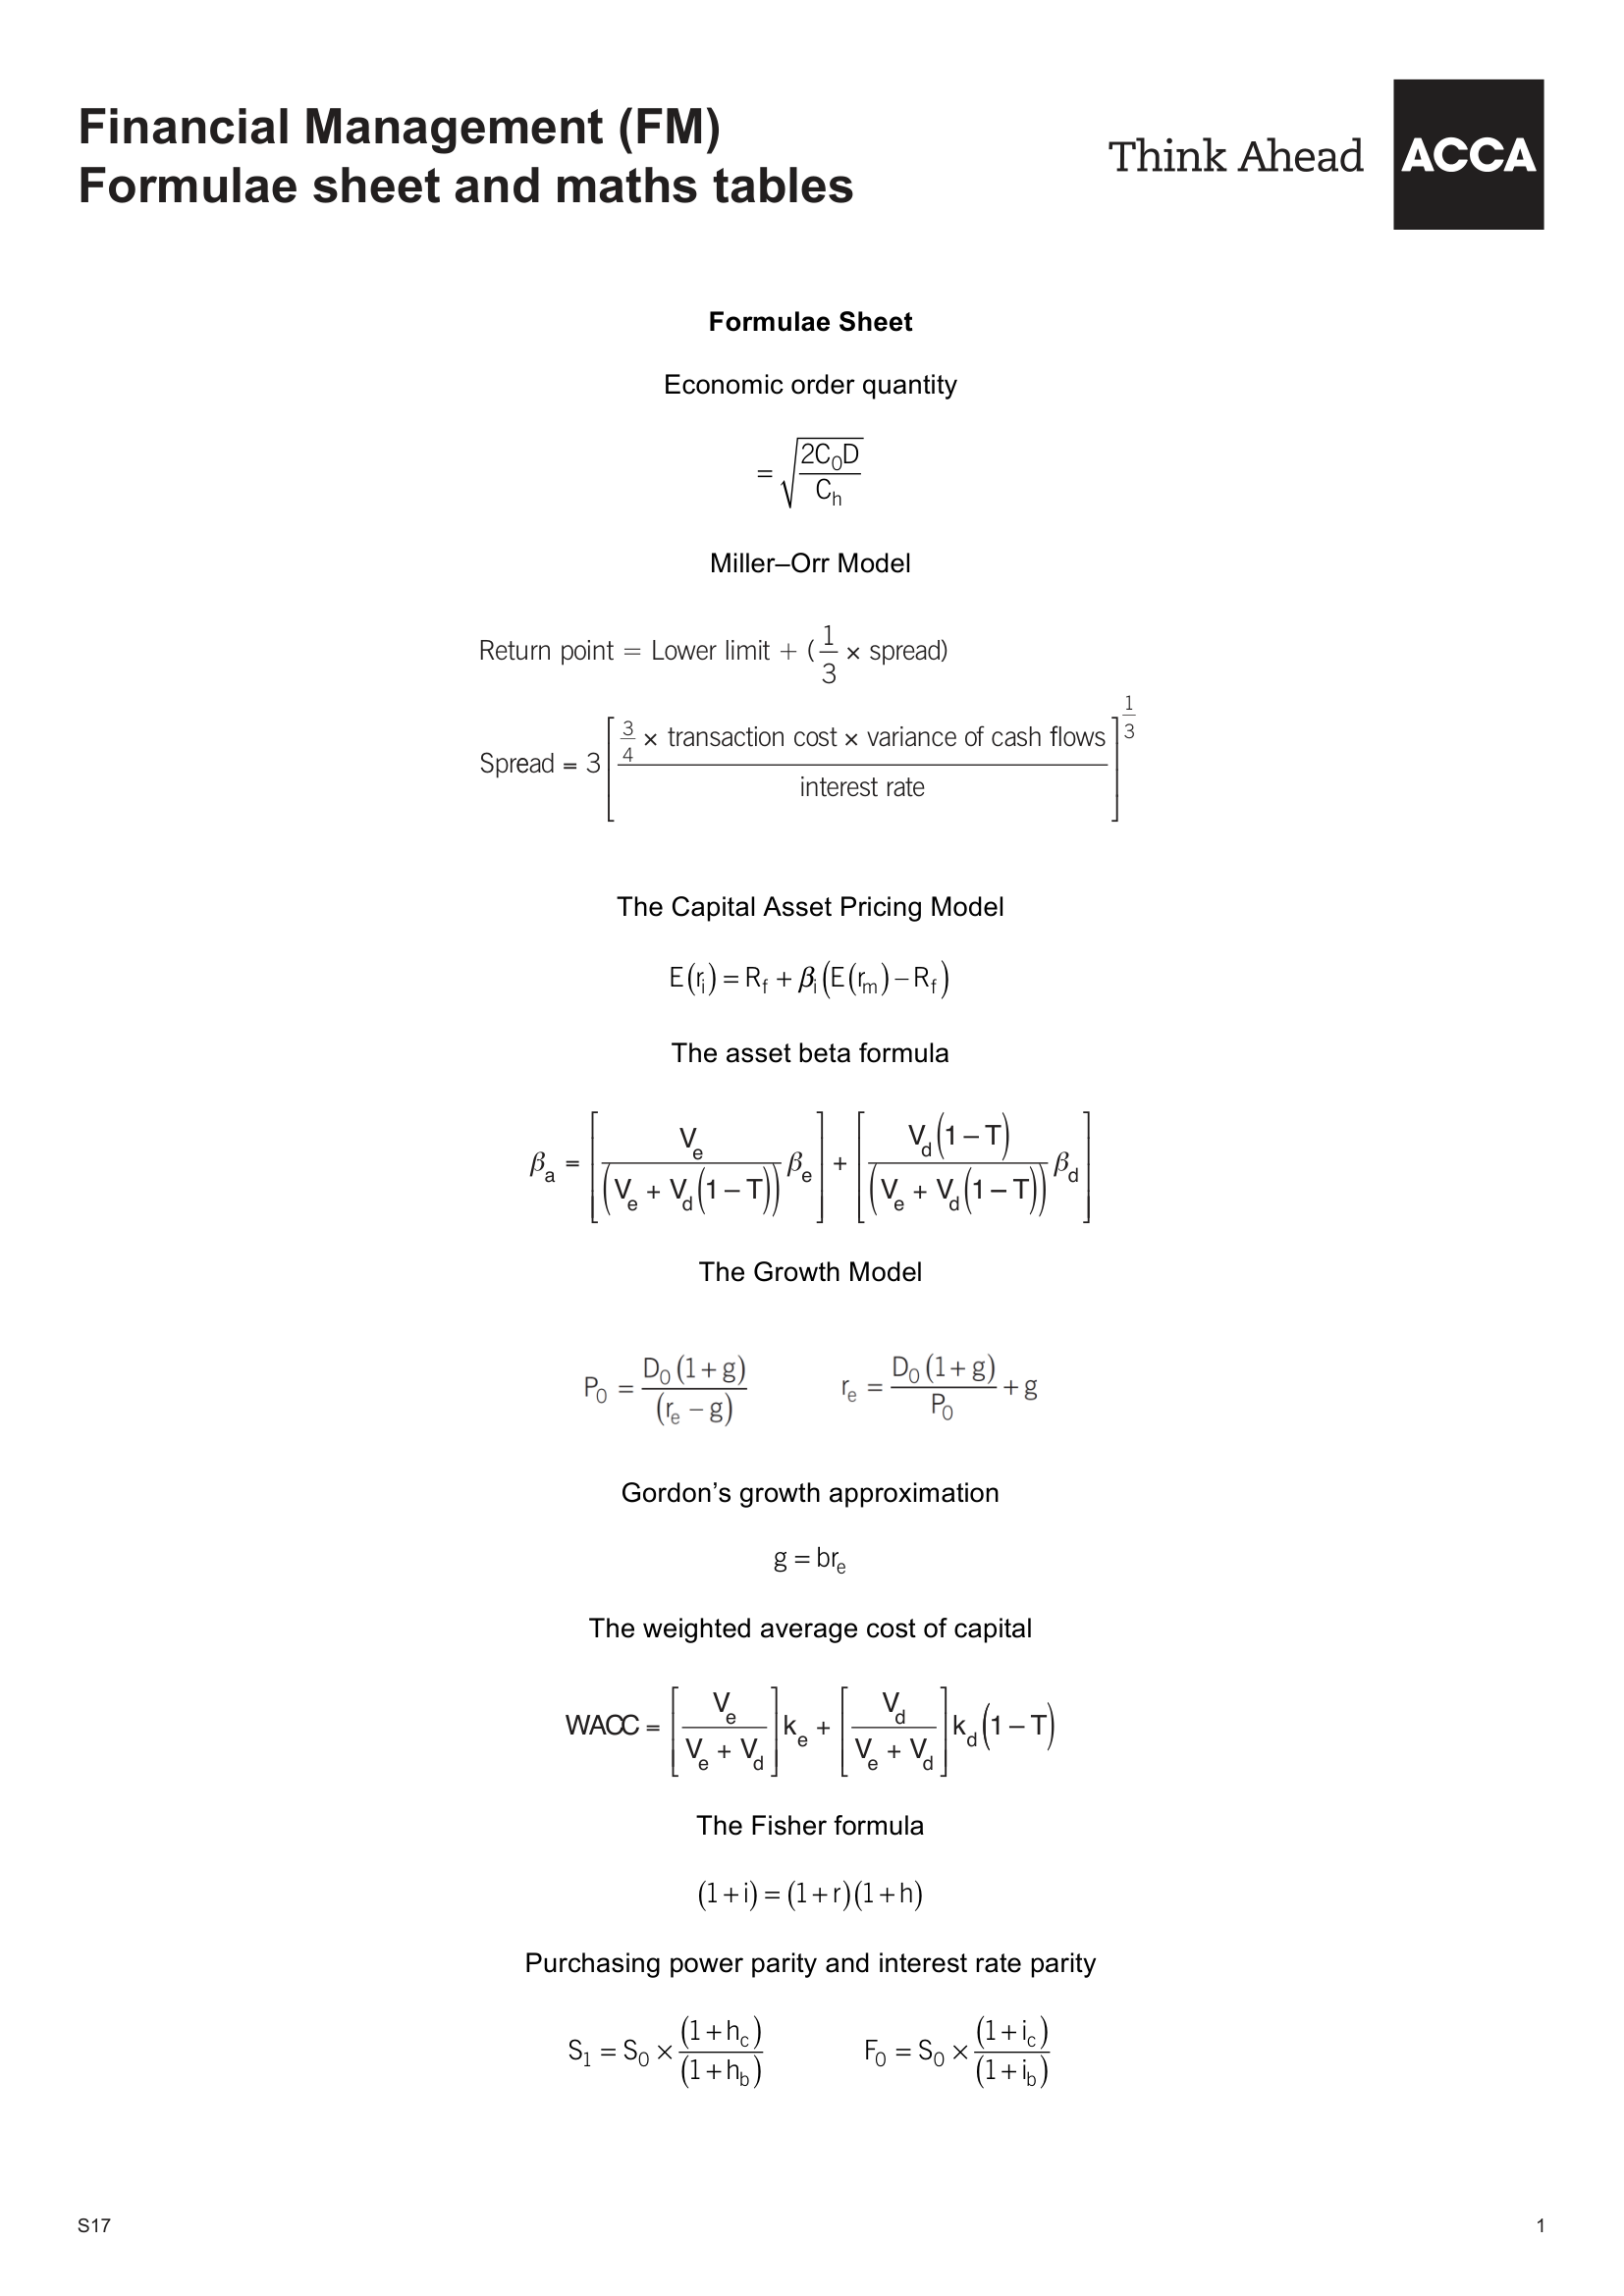


🚀 Invio a LM Studio (http://localhost:1234/v1/chat/completions)... Attendi...

📝 RISULTATO ESTRAZIONE



Financial Management (FM)
Formulae sheet and maths tables

Formulae Sheet

Economic order quantity
\[
= \sqrt{\frac{2C_0D}{C_h}}
\]

Miller–Orr Model

Return point = Lower limit + \(\left(\frac{1}{3} \times \text{spread}\right)\)

Spread = \(3 \left[ \frac{\frac{3}{4} \times \text{transaction cost} \times \text{variance of cash flows}}{\text{interest rate}} \right]^{\frac{1}{3}}\)

The Capital Asset Pricing Model
\[
E(r_i) = R_f + \beta_i (E(r_m) - R_f)
\]

The asset beta formula
\[
\beta_a = \left[ \frac{V_e}{(V_e + V_d(1-T))} \right] \beta_e + \left[ \frac{V_d(1-T)}{(V_e + V_d(1-T))} \right] \beta_d
\]

The Growth Model
\[
P_0 = \frac{D_0(1+g)}{(r_e - g)} \quad \quad r_e = \frac{D_0(1+g)}{P_0} + g
\]

Gordon’s growth approximation
\[
g = b r_e
\]

The weighted average cost of capital
\[
\text{WACC} = \left[ \frac{V_e}{V_e + V_d} \right] k_e + \left[ \frac{V_d}{V_e + V_d} \right] k_d (1-T)
\]

The Fisher formula
\[
(1+i) = (1+r)(1+h)
\]

Purchasing power parity and interest rate parity
\[
S_1 = S_0 \times \frac{(1+h_c)}{(1+h_b)} \quad \quad F_0 = S_0 \times \frac{(1+i_c)}{(1+i_b)}
\]


--- RAW LATEX/MARKDOWN ---
Financial Management (FM)
Formulae sheet and maths tables

Formulae Sheet

Economic order quantity
\[
= \sqrt{\frac{2C_0D}{C_h}}
\]

Miller–Orr Model

Return point = Lower limit + \(\left(\frac{1}{3} \times \text{spread}\right)\)

Spread = \(3 \left[ \frac{\frac{3}{4} \times \text{transaction cost} \times \text{variance of cash flows}}{\text{interest rate}} \right]^{\frac{1}{3}}\)

The Capital Asset Pricing Model
\[
E(r_i) = R_f + \beta_i (E(r_m) - R_f)
\]

The asset beta formula
\[
\beta_a = \left[ \frac{V_e}{(V_e + V_d(1-T))} \right] \beta_e + \left[ \frac{V_d(1-T)}{(V_e + V_d(1-T))} \right] \beta_d
\]

The Growth Model
\[
P_0 = \frac{D_0(1+g)}{(r_e - g)} \quad \quad r_e = \frac{D_0(1+g)}{P_0} + g
\]

Gordon’s growth approximation
\[
g = b r_e
\]

The weighted average cost of capital
\[
\text{WACC} = \left[ \frac{V_e}{V_e + V_d} \right] k_e + \left[ \frac{V_d}{V_e + V_d} \right] k_d (1-T)
\]

The Fisher formula
\[
(1+i) = (1+r)(1+h)
\]

Purchasing power pa

🔄 Apertura file: Formulae_Tables.pdf (Pagina 1)...
✅ Immagine renderizzata. Ecco cosa vedrà qwen/qwen3-vl-8b:


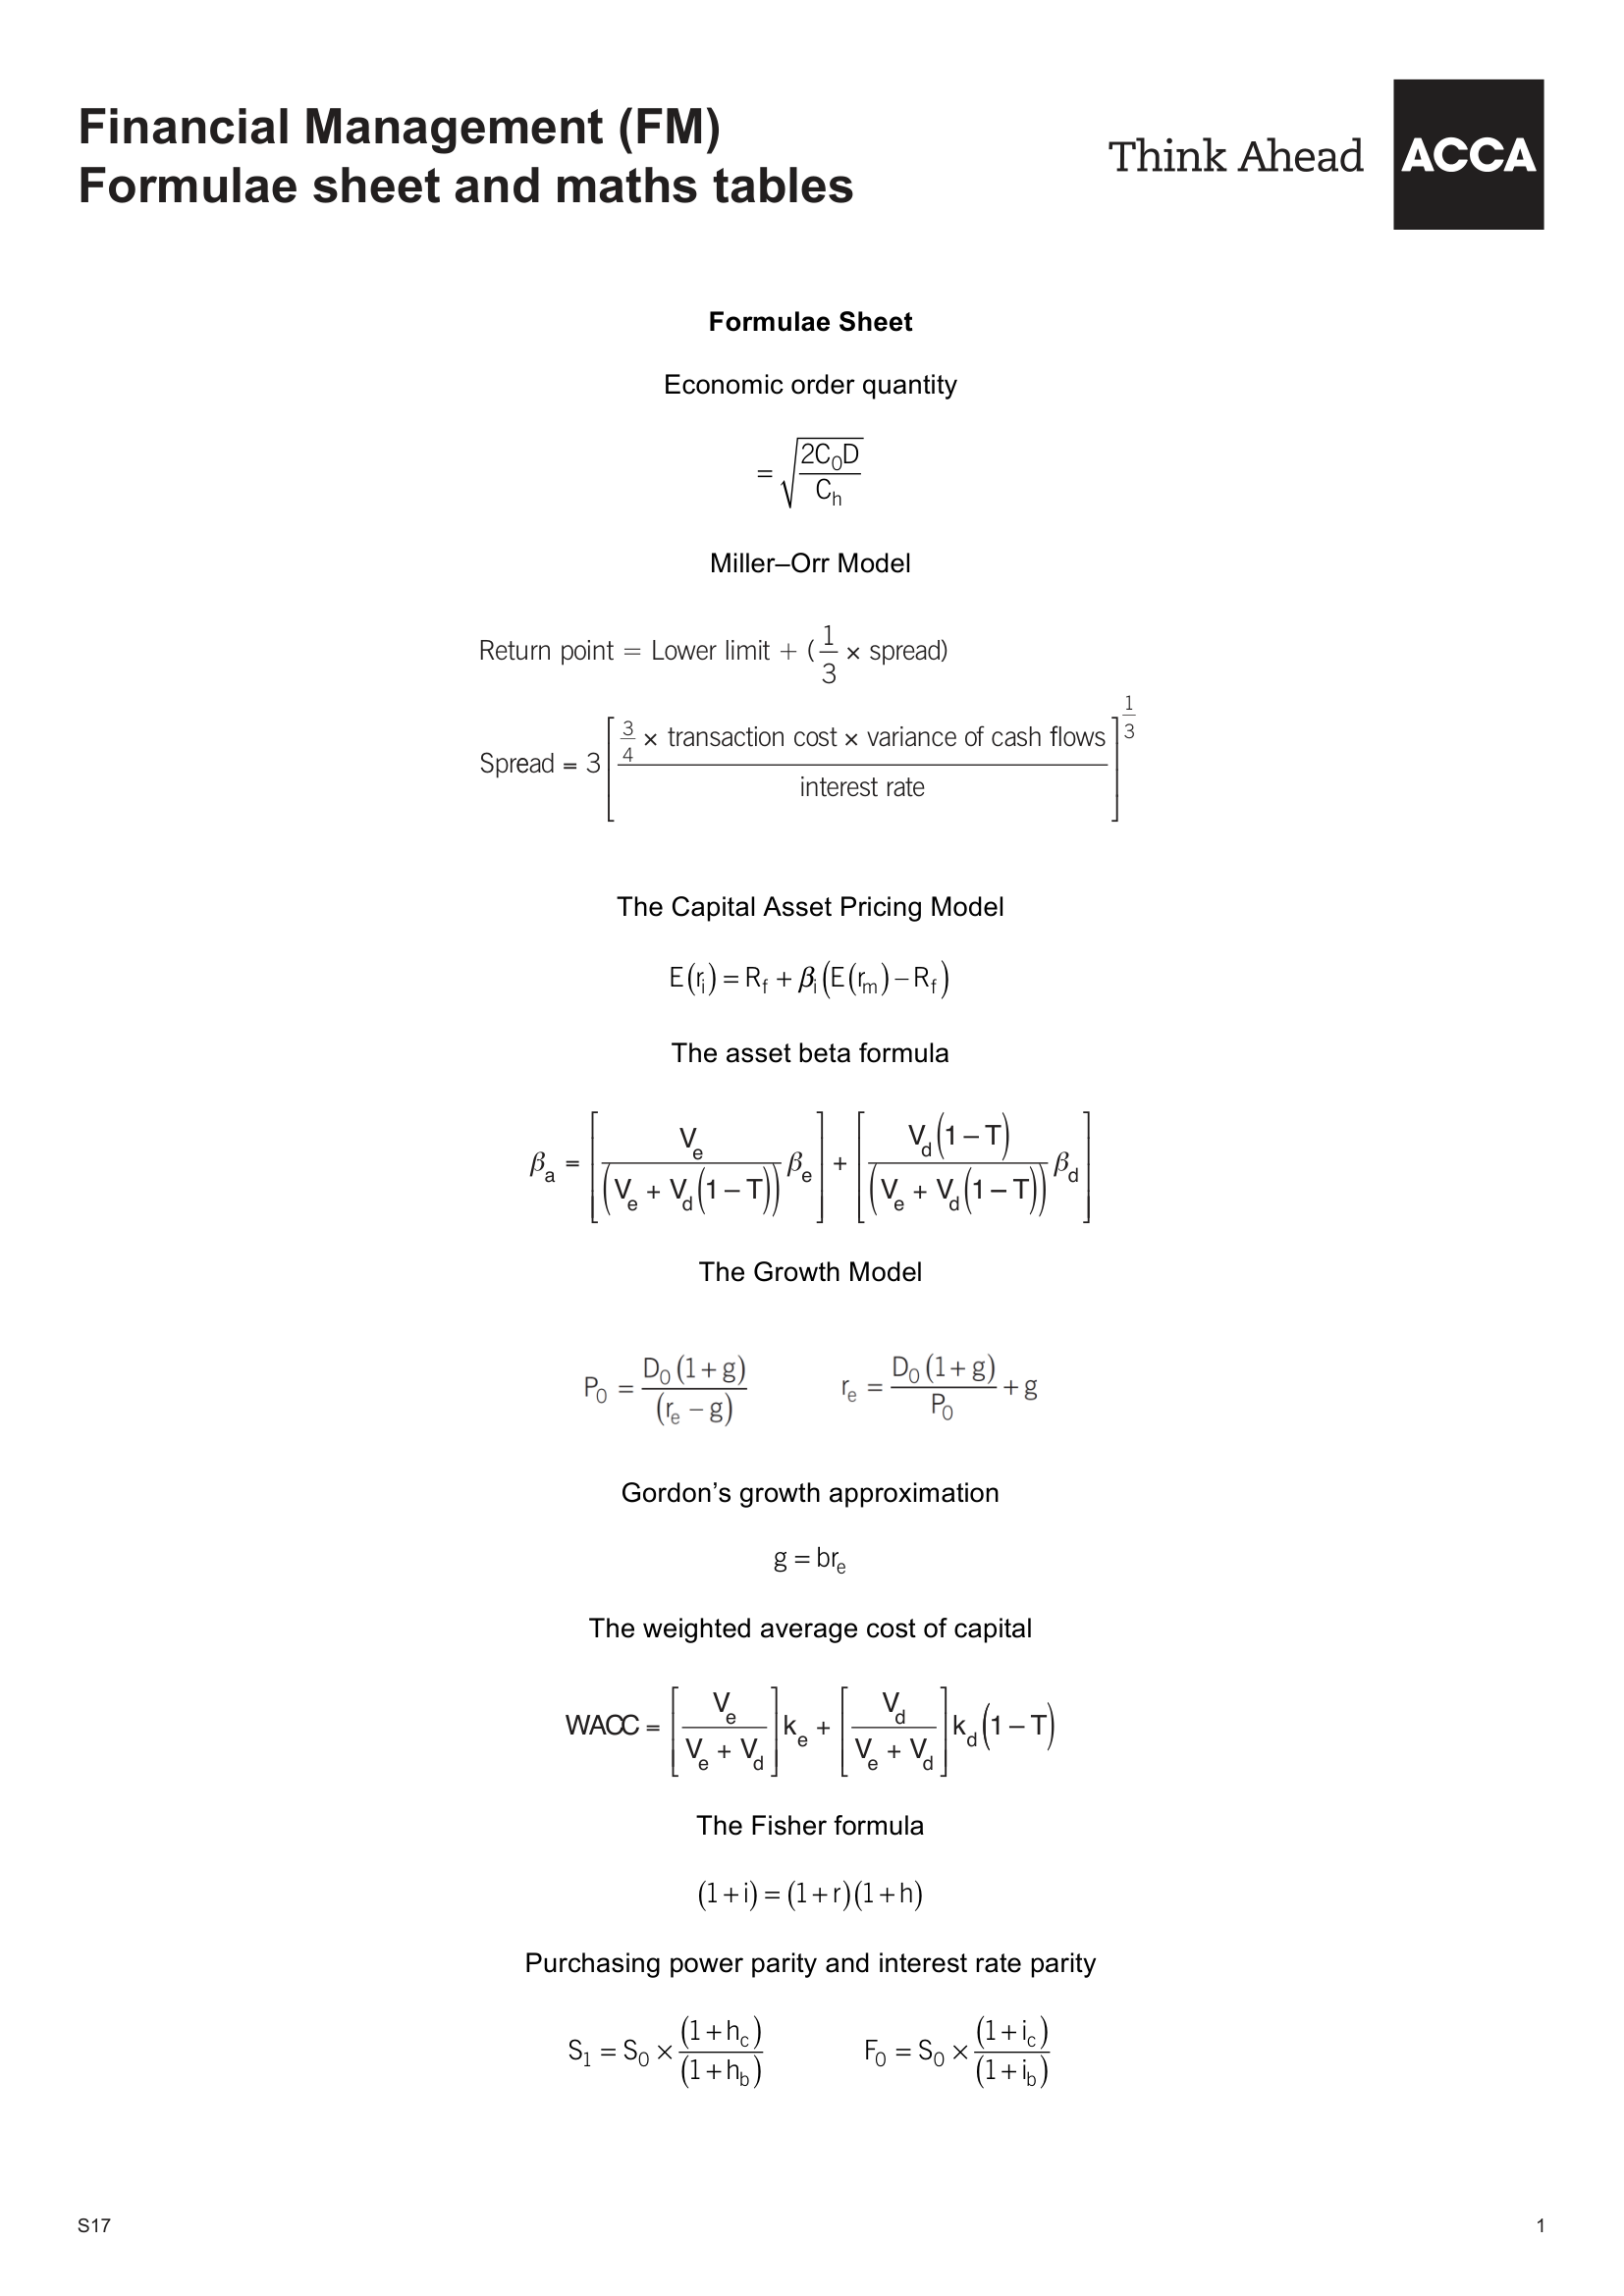


🚀 Invio a LM Studio (http://localhost:1234/v1/chat/completions)... Attendi...


In [ ]:
# ============================================================================
# VISION OCR CON LM STUDIO (Jupyter Notebook)
# ============================================================================
# Requisiti: 
# 1. pip install pymupdf requests ipython
# 2. Server LM Studio avviato su porta 1234
# ============================================================================

import os
import fitz  # PyMuPDF
import base64
import requests
import json
from IPython.display import display, Image, Markdown

# --- CONFIGURAZIONE ---
PDF_PATH = "Formulae_Tables.pdf"   # Il tuo file
PAGE_INDEX = 0                     # Pagina da analizzare (0 = prima pagina)
LM_STUDIO_URL = "http://localhost:1234/v1/chat/completions"

# Il nome qui è decorativo, LM Studio usa il modello che hai caricato nella UI
MODEL_NAME = "qwen/qwen3-vl-8b" 

# Prompt "Vision Supremacy" ottimizzato
PROMPT = """
You are a Scientific OCR Engine.
Transcribe the visual content of this page.
1. Ignore corrupt text artifacts like '2C0D'.
2. Identify formulas and write them in standard LaTeX (e.g., \\sqrt{...}).
3. Identify tables and write them in Markdown.
4. Do not describe the layout, just transcribe the content.
"""

# --- FUNZIONI ---

def get_image_data_uri(page):
    """Renderizza la pagina PDF e crea una stringa Data URI per LM Studio"""
    # 200 DPI è il bilanciamento perfetto tra qualità e velocità per Qwen
    pix = page.get_pixmap(dpi=200)
    img_bytes = pix.tobytes("png")
    b64 = base64.b64encode(img_bytes).decode('utf-8')
    
    # Questo formato è richiesto dalle API OpenAI-compatible di LM Studio
    return f"data:image/png;base64,{b64}", img_bytes

def test_lmstudio_vision():
    print(f"🔄 Apertura file: {PDF_PATH} (Pagina {PAGE_INDEX + 1})...")
    
    if not os.path.exists(PDF_PATH):
        print("❌ ERRORE: File PDF non trovato.")
        return

    # 1. RENDERING IMMAGINE
    try:
        doc = fitz.open(PDF_PATH)
        page = doc.load_page(PAGE_INDEX)
        
        data_uri, raw_bytes = get_image_data_uri(page)
        
        print(f"✅ Immagine renderizzata. Ecco cosa vedrà {MODEL_NAME}:")
        display(Image(data=raw_bytes, width=600))
        
        doc.close()
    except Exception as e:
        print(f"❌ ERRORE Rendering: {e}")
        return

    # 2. CHIAMATA LM STUDIO
    print(f"\n🚀 Invio a LM Studio ({LM_STUDIO_URL})... Attendi...")
    
    payload = {
        "model": MODEL_NAME,
        "messages": [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": PROMPT},
                    {
                        "type": "image_url",
                        "image_url": {"url": data_uri}
                    }
                ]
            }
        ],
        "temperature": 0.1, # Bassa temperatura = Precisione OCR
        "max_tokens": 4096,
        "stream": False
    }

    headers = {"Content-Type": "application/json"}

    try:
        response = requests.post(LM_STUDIO_URL, json=payload, headers=headers, timeout=120)
        
        if response.status_code == 200:
            result = response.json()
            content = result['choices'][0]['message']['content']
            
            print("\n" + "="*40)
            print("📝 RISULTATO ESTRAZIONE")
            print("="*40 + "\n")
            
            # Rendering Markdown nel notebook
            display(Markdown(content))
            
            print("\n--- RAW LATEX/MARKDOWN ---")
            print(content)
            
        else:
            print(f"❌ ERRORE API: {response.status_code}")
            print(response.text)
            print("💡 SUGGERIMENTO: Controlla che il Server LM Studio sia AVVIATO (tasto verde).")

    except requests.exceptions.ConnectionError:
        print("❌ ERRORE CONNESSIONE: Impossibile contattare localhost:1234.")
        print("   -> Apri LM Studio -> Tab Developer -> Clicca 'Start Server'.")
    except Exception as e:
        print(f"❌ ERRORE GENERICO: {e}")

# --- ESECUZIONE ---
test_lmstudio_vision()

In [1]:
import os
import fitz  # PyMuPDF
import base64
import time
from ollama import chat, ChatResponse

# ================= CONFIGURAZIONE =================
# FILE DA LEGGERE
PDF_PATH = "Formulae_Tables.pdf"

# MODELLO (Assicurati che sia presente in 'ollama list')
MODEL_NAME = "ministral-3:3b"

# CONFIGURAZIONE CHUNKING
CHUNK_MAX_CHARS = 1000  # Dimensione massima del chunk
CHUNK_OVERLAP = 200     # Sovrapposizione

# Configurazione Rendering (DPI ottimizzato per bilanciare velocità/qualità)
VISION_DPI = 120  

# PROMPT VISIONE (Versione "Clean Math" - Formattazione pulita)
PROMPT = r"""
You are a Scientific OCR Engine specialized in creating clean, human-readable documents.
Transcribe the visual content of this page adhering to these STRICT formatting rules:

1. **NO LATEX CODE**: Do NOT use backslashes, braces, or dollar signs (e.g., avoid \frac, \sqrt, $, $$).
2. **Mathematical Formulas**:
   - Use standard Unicode symbols for math: +, -, =, ≈, ≠, ≤, ≥, ±.
   - Use Unicode for greek letters: α, β, π, Δ, Σ, σ, μ.
   - Use Unicode for superscripts/subscripts if possible: x², H₂O.
   - Use symbols for operations: √ (root), ∫ (integral), ∑ (sum), ∂ (partial).
   - Represent fractions cleanly, e.g., "a / b" or "(x + y) / z".
   - Example: instead of "$\frac{E}{c^2}$", write "E / c²".
3. **Tables**: Keep representing tables using Markdown for structure.
4. **General Text**: Transcribe exactly as seen.
5. **No Chatter**: Output ONLY the content. No introductory phrases.
6. **Empty Pages**: Reply "NO_CONTENT".
"""

# ================= FUNZIONI DI SUPPORTO =================

def image_to_base64(page):
    """Renderizza la pagina PDF in immagine e la converte in base64"""
    # Matrix per settare i DPI (150 DPI ≈ zoom 2.08 su base 72 DPI)
    zoom = VISION_DPI / 72
    mat = fitz.Matrix(zoom, zoom)
    
    pix = page.get_pixmap(matrix=mat, alpha=False)
    img_bytes = pix.tobytes("png")
    return base64.b64encode(img_bytes).decode("utf-8")

def recurse_text_chunking(text: str, page_num: int, filename: str, max_chars: int = 1000) -> list:
    """
    Divide il testo ricorsivamente cercando di non spezzare frasi o formule.
    Priorità di taglio: Doppia linea -> Linea singola -> Punto -> Spazio.
    """
    text = text.strip()
    if not text:
        return []

    # CASO BASE: Il testo rientra nella dimensione massima
    if len(text) <= max_chars:
        return [{
            "text": text,
            "metadata": {
                "source": filename,
                "page": page_num,
                "char_count": len(text)
            }
        }]

    # LOGICA RICORSIVA
    chunks = []
    separators = ["\n\n", "\n", ". ", " "]
    split_char = ""
    
    for sep in separators:
        if sep in text and len(text.split(sep)) > 1:
            split_char = sep
            break
    
    # Se nessun separatore trovato, taglio a metà
    if not split_char:
        mid = len(text) // 2
        return (
            recurse_text_chunking(text[:mid], page_num, filename, max_chars) + 
            recurse_text_chunking(text[mid:], page_num, filename, max_chars)
        )

    # Accumulatore
    raw_parts = text.split(split_char)
    current_chunk_str = ""
    
    for part in raw_parts:
        candidate = part if not current_chunk_str else (current_chunk_str + split_char + part)
        
        if len(candidate) <= max_chars:
            current_chunk_str = candidate
        else:
            if current_chunk_str:
                chunks.extend(recurse_text_chunking(current_chunk_str, page_num, filename, max_chars))
            current_chunk_str = part

    if current_chunk_str:
        chunks.extend(recurse_text_chunking(current_chunk_str, page_num, filename, max_chars))

    return chunks

# ================= MOTORE PRINCIPALE =================

def process_pdf_ollama_native():
    print(f"📄 Apertura file: {PDF_PATH}")

    if not os.path.exists(PDF_PATH):
        print(f"❌ Errore: Il file {PDF_PATH} non esiste.")
        return

    try:
        doc = fitz.open(PDF_PATH)
    except Exception as e:
        print(f"❌ Errore apertura PDF: {e}")
        return

    total_pages = len(doc)
    print(f"📊 Totale pagine: {total_pages}")
    print(f"🧠 Modello: {MODEL_NAME} (Libreria Ollama nativa)\n")

    full_chunks_collection = []

    # --- CICLO PAGINE ---
    for i, page in enumerate(doc):
        page_num = i + 1
        print(f"🔹 Elaborazione Pagina {page_num}/{total_pages}...", end="", flush=True)

        # 1. Rendering immagine
        try:
            img_b64 = image_to_base64(page)
        except Exception as e:
            print(f" ❌ Errore Rendering: {e}")
            continue

        # 2. Chiamata Ollama (Libreria Nativa)
        try:
            start_time = time.time()

            response: ChatResponse = chat(
                model=MODEL_NAME,
                messages=[
                    {
                        "role": "user",
                        "content": PROMPT,
                        "images": [img_b64]
                    }
                ],
                options={
                    "temperature": 0.0,
                    "num_ctx": 4096 # Fondamentale per contesti visivi ampi
                }
            )
            
            elapsed = time.time() - start_time

            # Verifica e estrazione contenuto
            content = ""
            if response.message and response.message.content:
                content = response.message.content
            
            if content and "NO_CONTENT" not in content:
                print(f" ✅ Fatto in {elapsed:.1f}s")
                
                # --- STAMPA OUTPUT ---
                print("\n" + "─"*60)
                print(f"📝 OUTPUT PAGINA {page_num}:")
                print("─"*60)
                print(content)
                print("─"*60 + "\n")
                # ---------------------

                # 3. GENERAZIONE CHUNK
                print(f"   ✂️ Generazione chunks...")
                
                # Header semantico
                semantic_content = f"Documento: {os.path.basename(PDF_PATH)} | Pagina: {page_num}\n{content}"
                
                page_chunks = recurse_text_chunking(
                    semantic_content, 
                    page_num, 
                    os.path.basename(PDF_PATH), 
                    CHUNK_MAX_CHARS
                )
                
                full_chunks_collection.extend(page_chunks)
                print(f"   📦 {len(page_chunks)} chunk(s) creati.")

            else:
                print(f" ⚠️ Nessun contenuto utile rilevato (o pagina vuota).")

        except Exception as e:
            print(f"\n❌ Errore chiamata Ollama: {e}")

    print("\n" + "="*60)
    print(f"🏁 ELABORAZIONE COMPLETATA")
    print(f"📦 Totale Chunks Generati: {len(full_chunks_collection)}")
    print("="*60)

if __name__ == "__main__":
    process_pdf_ollama_native()

📄 Apertura file: Formulae_Tables.pdf
📊 Totale pagine: 3
🧠 Modello: ministral-3:3b (Libreria Ollama nativa)

🔹 Elaborazione Pagina 1/3... ✅ Fatto in 95.6s

────────────────────────────────────────────────────────────
📝 OUTPUT PAGINA 1:
────────────────────────────────────────────────────────────
Financial Management (FM)
Formulae sheet and maths tables

---

**Economic order quantity**
Economic order quantity = √(2C₀D / Cₕ)

---

**Miller–Orr Model**

Return point = Lower limit + (1 / 3 × spread)

Spread = (3 / 4) × transaction cost × variance of cash flows^(1/3) / interest rate

---

**The Capital Asset Pricing Model**
E(fᵢ) = Rᵢ + β(E(rₘ) – Rᵢ)

---

**The asset beta formula**
βₐ = [Vₑ / (Vₑ + Vₑ(1 – T))] βₑ + [Vₑ(1 – T) / (Vₑ + Vₑ(1 – T))] βₑ + [Vₑ / (Vₑ + Vₑ(1 – T))] βₚ

*(Note: There appears to be a typo in the original image; it should be corrected to:)*
βₐ = [Vₑ / (Vₑ + Vₑ(1 – T))] βₑ + [Vₑ(1 – T) / (Vₑ + Vₑ(1 – T))] βₚ

*(Assuming Vₑ is equity and Vₑ(1 – T) is debt after tax.) H

In [15]:
import ollama
import os

# Sostituisci con il percorso reale della tua immagine
image_path = r"./image_smple/graph_china.png" 

if not os.path.exists(image_path):
    print(f"❌ Errore: File non trovato: {image_path}")
    exit()

print(f"🔎 Analisi glm-4.7-flash:q4_K_M...")

response = ollama.chat(
    model='glm-4.7-flash:q4_K_M',
    messages=[{
        'role': 'user',
        'content': 'Descrivi questo grafico focalizzandoti sugli assi e la legenda. Dimmi esattamente quali anni vedi sull\'asse X. Estrari i valori delle Y in funzionee dei dati/etichette delle X',
        'images': [image_path]
    }]
)

print("\n--- RISPOSTA ---")
print(response['message']['content'])

🔎 Analisi glm-4.7-flash:q4_K_M...

--- RISPOSTA ---
Mi dispiace, ma non riesco a visualizzare l'immagine [img-0] a cui fai riferimento. Come modello linguistico, non ho accesso diretto ai dati visivi se non sono stati processati nel contesto della conversazione.

Per favore, descrivi il grafico (ad esempio: quali sono gli anni sull'asse X e i valori sull'asse Y) o incolla i dati che vedi, così potrò aiutarti con l'analisi.
